# Sui_Wenyu_HW3_report

In [1]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.neighbors import KernelDensity
import scipy.io as sio
from scipy import stats
from sklearn import preprocessing
import seaborn
from scipy.stats import multivariate_normal as mvn
import functions

## 1. Conceptual questions.

### 1.1

**Histogram:** <br>
**Pro:** 
1. Easy to implement and interpret. 

**Cons:**
1. Histograms are not sample efficient for high-dimensioanl data.
2. The output depends on where the bins are placed, so the estimates derived from histograms can be noisy.
<br> <br>

**KDE:**<br>
**Pros:**
1. The output is less arbitrary than histograms since there are no "bins"
2. KDE has smaller error than histograms, comparing to the true probability density functiopn.

**Cons:**
1. KDE costs more computation power to derive.

### 1.2

To use MLE to estimate GMM, we define $\theta$ to be the parameters for the K Gaussain distributions, where $\theta = (\pi_k, \mu_k, \sum_k)$.

The MLE of $\theta$, $\hat{\theta} = argmax \space l(\theta; D)$.

The likehood function <br>
$l(\theta; D) = log \prod_{i=1}^m(\sum_{k=1}^Kp(x^i, z^i=k|\theta))$<br>
where $z^i =k$ represents that the $i$th datapoints belongs to the $k$th Gaussian distribution.

Since we do not know the latent factors $z^i$. Therefore, we cannot evaluate $l(\theta; D)$ directly.

To estimate GMM, we need to use the EM Algorithm. Here are the major steps:
1. Associate the $i$ th data and each component with a $\tau_k^i$
2. Initialize $(\pi_k, \mu_k, \sum_k)$, $k =1...K$
3. Iterate the following two steps till convergence: <br><br>
    (1) Expectation step (E-step): update $\tau_k^i$ given current $(\pi_k, \mu_k, \sum_k)$ <BR><br>
     $\tau_k^i = P(z_k^i =1|D, \mu, \sum) = \frac{\pi_k N(x_i|\mu_k, \sum_k)}{\sum_{k'=1}^K \pi_{k'} N(x_i|\mu_{k'}, \sum_{k'})}$
    
    $(k=1...K, i=1...m)$ <br><br><br>
    
    (2) Maximization step (M-step): update $(\pi_k, \mu_k, \sum_k)$ given  $\tau_k^i$  <br>
    $\pi_k = \frac{\sum_i\tau_k^i}{m}$, <br> <br>
    $\mu = \frac{\sum_i \tau_k^i x^i}{\sum_i \tau_k^i}$ <br><br>
    $\sum_k = \frac{\sum_i \tau_k^i (x^i-\mu_k)(x^i - \mu_k)^T}{\sum_i \tau_k^i}$
    
    $(k=1...K, i=1...m)$

### 1.3

According to Bayes Rule, $P(z|x) = \frac{P(x|z)P(z)}{P(x)} = \frac{P(x,z)}{\sum_{z`}P(x,z`)}$

To derive $\tau_k^i$, we have <br><br>
$P(x|z) = p(x^i | z^i = k)$ <br>
$P(z) = p(z^i = k)$ <br>
$\sum_{z'}P(x,z') = \sum_{k'=1}^K p(z^i = k', x^i)$

Therefore, $\tau_k^i = p(z^i=k|x^i,\theta) = \frac{p(x^i | z^i = k) p(z^i = k)}{\sum_{k'=1}^K p(z^i = k', x^i)} = \frac{\pi_k N(x^i|\mu_k, \sum_k)}{\sum_{k'=1}^K \pi_{k'} N(x_i|\mu_{k'}, \sum_{k'})}$

## 2. Density estimation: Psychological experiments.

### 2.a

The histograms and KDEs of **amygdala** and **acc** are shown in the following code chunk respectively. <br>
When using the histograms, we set the number of bins to be 20 for each variable. <br>
When using KDE, we set up the kernel bandwidth $h$ using the formula given in the lecture:

$h  \approx 1.06 \space \hat{\sigma} m^{-\frac{1}{5}}$

By using this formula, we can calculate that for **amygdala**, $h_{amygdala} \approx 0.01397$; for **acc**, $h_{acc} \approx 0.00876$.<br>
Therefore, we  use the average of these two values as our final $h$ value, $h_{avg} = (0.01397 + 0.00876)\div 2 \approx 0.01137$

$h_{avg}$ will be used in all the following questions.

*(reference: https://scikit-learn.org/stable/modules/density.html, https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html)*

In [2]:
# read data
n90pol = pd.read_csv(f'data/n90pol.csv')
amygdala = np.array(n90pol['amygdala'])
acc = np.array(n90pol['acc'])

n90data = np.array(n90pol)[:, 0:2]
n90y = np.array(n90pol)[:, 2]

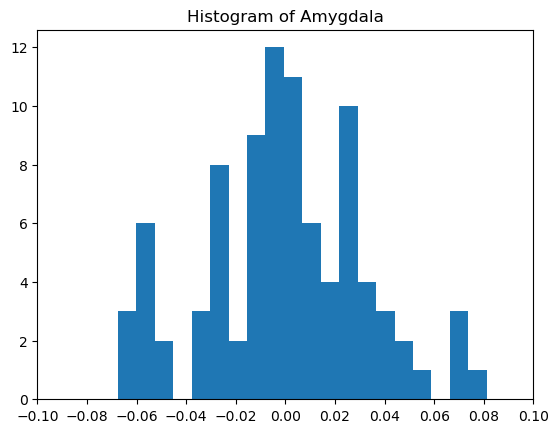

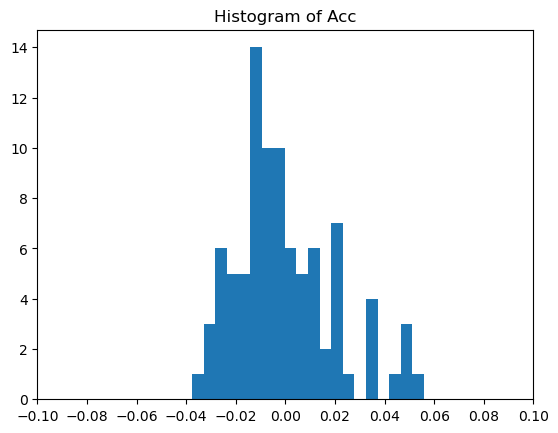

In [3]:
# display histogram of amygdala
plt.figure()
plt.hist(amygdala, bins = 20)
plt.title('Histogram of Amygdala')
plt.xticks(np.arange(-0.1,0.12, 0.02))
plt.show()

# display histogram of acc
plt.figure()
plt.hist(acc, bins = 20)
plt.xticks(np.arange(-0.1,0.12, 0.02))
plt.title('Histogram of Acc')
plt.show()

For amygdala, h equals: 0.013973984566878187
For acc, h equals: 0.008758179725254512
Average h value =  0.01136608214606635


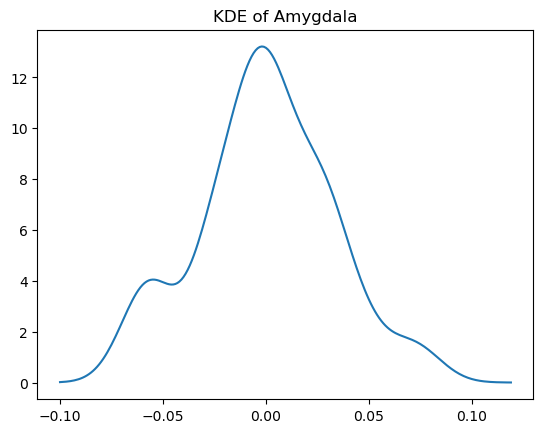

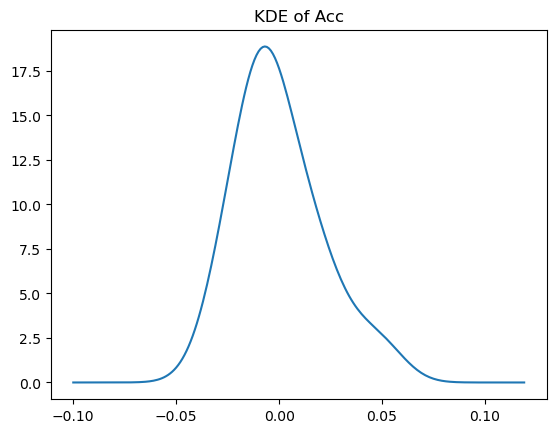

In [4]:
# determine h value
stdev = np.std(amygdala)
h = 1.06 * stdev / np.power(amygdala.shape[0], 0.2)
print("For amygdala, h equals:", h)

stdev2 = np.std(acc)
h2 = 1.06 * stdev2 / np.power(acc.shape[0], 0.2)
print("For acc, h equals:", h2)

h_avg = (h+h2)/2
print("Average h value = ", h_avg)

# display KDE of amygdala
# set up h value for KDE using Silverman’s rule of thumb
plt.figure()
kde = KernelDensity(kernel='gaussian', bandwidth = h_avg).fit(amygdala.reshape(-1,1))

x = np.arange(-0.1, 0.12, 0.001)
log_density = kde.score_samples(x.reshape(-1,1))
density = np.exp(log_density)
plt.plot(x, density)
plt.title("KDE of Amygdala")
plt.show()

# display KDE of acc
plt.clf()
kde2 = KernelDensity(kernel='gaussian', bandwidth = h_avg).fit(acc.reshape(-1,1))

x2 = np.arange(-0.1, 0.12, 0.001)
log_density2 = kde2.score_samples(x2.reshape(-1,1))
density2 = np.exp(log_density2)
plt.plot(x2, density2)
plt.title("KDE of Acc")
plt.show()

### 2.b

The two-dimensional histogram is shown in the code chunk below. Here we set the number of bins to be 10 and 20 respectively .

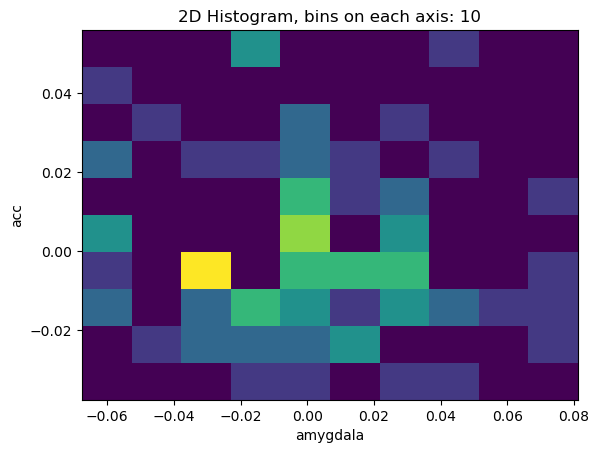

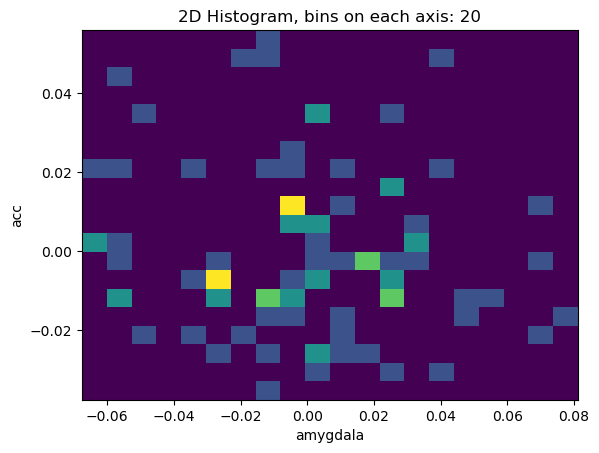

In [5]:
functions. TwoD_histogram(data = n90data, nbin = 10,\
                                                   xlabel = n90pol.columns[0], \
                                                   ylabel = n90pol.columns[1])

functions. TwoD_histogram(data = n90data, nbin = 20,\
                                                   xlabel = n90pol.columns[0], \
                                                   ylabel = n90pol.columns[1])

### 2.c

Here are the findings for this question:

1. The two-dimensional KDE is displayed in the first code chunk below. (in both 3D histogram and heatmap)
2. From the 3D histogram displayed below,  the distribution is bimodal. We can observe in the heatmap that there are a few outliers in the dataset.
3. Here are the steps to verify if the two variables are indepent: <br> <br>
    (1) we define $p_{amygdala}(x)$ to be the probability density function derived from KDE of **amygdala** alone. $p_{acc}(y)$ is the pdf derived from KDE of **acc** alone.  $p_{joint}(x, y)$ is the joint pdf derived from the 2-dimensional KDE of **amygdala** and **acc**.<br><br>
    (2) If **amygdala** and **acc** are independdent, $p_{amygdala}(x) \times p_{acc}(y)$ should equal to  $p_{joint}(x, y)$.<br><br>
    (3) We choose 220 values of $x$ from [-0.1, 0.12] and 220 values of $y$ from  [-0.1, 0.12] . $x$ and $y$ are indenpendent.<br>
    For each combination of $x$ and $y$, we calculate $z = |p_{amygdala}(x) \times p_{acc}(y) - p_{joint}(x, y)|$ . In the end, we obtained 48,400 values of $z$.<br>
    If **amygdala** and **acc** are independdent, $\bar{z} = 0$.
    <br><br>
    (4) We perform a Student's t-test on the $z$ values obtained in the last step, where $ H_0: \bar{z} = 0$ <br>
    The results of the t-test shows $p-value = 0$. Thus, we reject the null hypothesis and conclude that $\bar{z} \neq 0$.    Therefore, **amygdala** and **acc** are not independent.

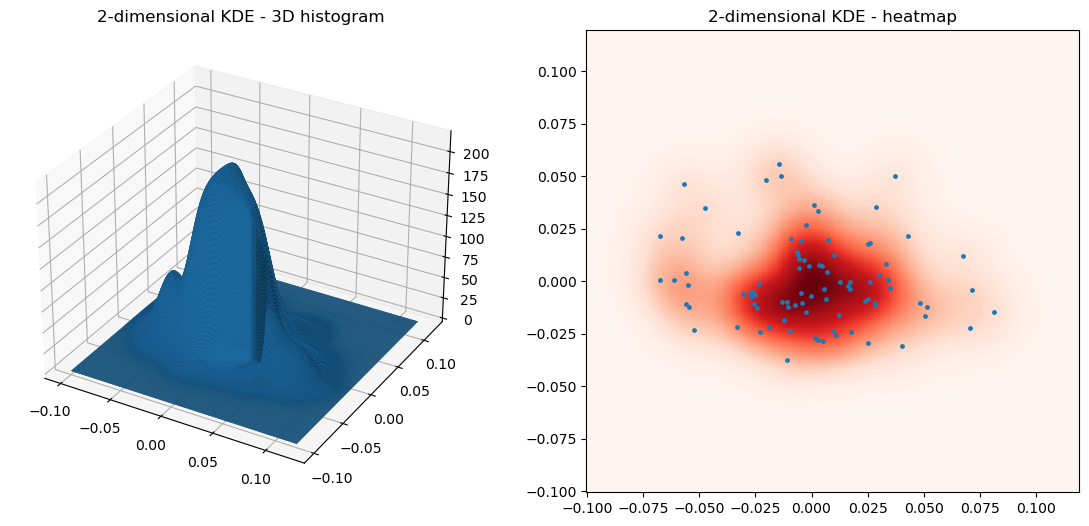

In [6]:
# 2-dimensional KDE in 3D histogram
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(1, 2, 1, projection = '3d')

kde3 = KernelDensity(kernel='gaussian', bandwidth = h_avg).fit(n90data)

x = np.arange(-0.1, 0.12, 0.001)
xpos, ypos = np.meshgrid(x, x)
xpos = xpos.flatten()
ypos = ypos.flatten()
pos = np.concatenate((xpos.reshape(-1,1), ypos.reshape(-1,1)), axis = 1)

log_density3 = kde3.score_samples(pos)
density3 = np.exp(log_density3)

zpos = np.zeros_like (xpos)

ax.bar3d(xpos, ypos, zpos, 0.001, 0.001, density3)

plt.title("2-dimensional KDE - 3D histogram")


# 2-dimensional KDE in heatmap
ax = plt.subplot(1, 2, 2)
zz = density3.reshape(x.shape[0], x.shape[0])
ax.pcolormesh(x, x, zz, shading='auto', cmap="Reds")
plt.scatter(n90data[:, 0], n90data[:,1],  s=6)
plt.title("2-dimensional KDE - heatmap")
plt.show()

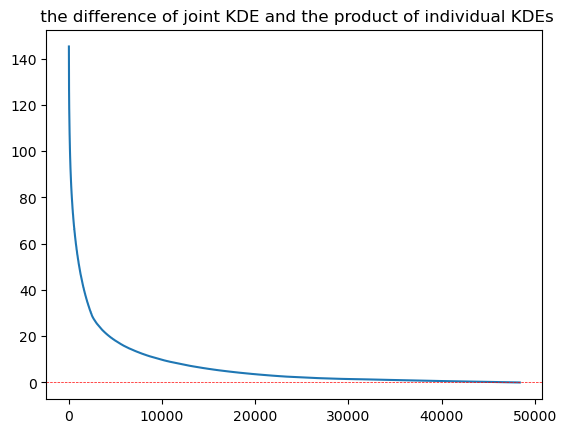

t-statistic = 121.9701
p-value = 0.0


In [7]:
# check if the two variables are inpendence
# show the difference of joint KDE and the product of individual KDE in a line chart
x = np.arange(-0.1, 0.12, 0.001)
y = x

error = []
for i in x:
    for j in y:
        prob1 =  kde.score_samples(np.array(i).reshape(-1,1))[0]
        prob2 =  kde2.score_samples(np.array(j).reshape(-1,1))[0]
        prob3 =  kde3.score_samples(np.array([i,j]).reshape(1,2))[0]
        error += [prob3 - prob1 * prob2] 

error = np.abs((np.array(error)))
error = error[np.argsort(-error)]

plt.figure()
plt.plot(error)
plt.axhline(y=0, color='r', linestyle='--',  linewidth = 0.5)
plt.title(' the difference of joint KDE and the product of individual KDEs')
plt.show()

# conduct a t-test
# using the stats library, compute t-statistic and p-value
t_stat, p_val = stats.ttest_1samp(a=error, popmean = 0)
print("t-statistic = " + str(round(t_stat,4)))  
print("p-value = " + str(round(p_val,4))) 

### 2.d

The estimated conditional distribution of **amygdala**, $p(amygdala|orientation = c)$ and the  estimated conditional distribution of **acc**, $p(acc|orientation = c)$ are displayed in the following code chunk. ($c =2,3,4,5$)

It can be observed that the conditional distribution of **amygdala** is different from $c = 2,3,4,5$, but there's not too much differentce for the conditional distribution of **acc**. Therefore, there is a difference between brain structure and political view in terms of **amygdala**, but not in terms of **acc**.

The table is filled out as below:

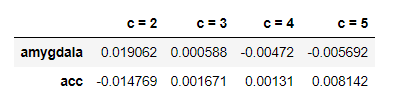

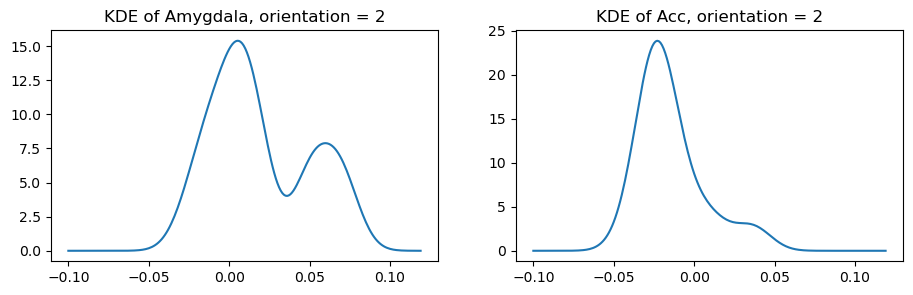

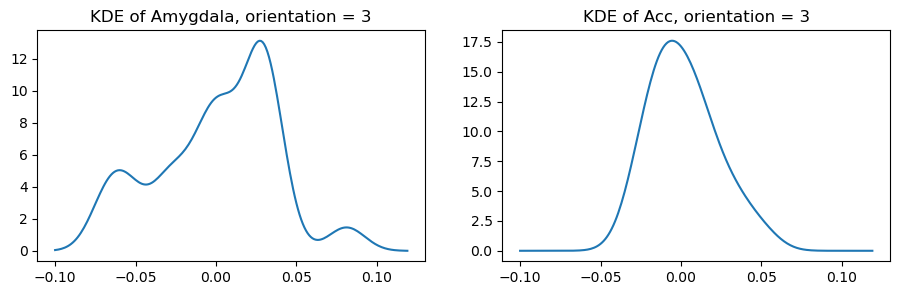

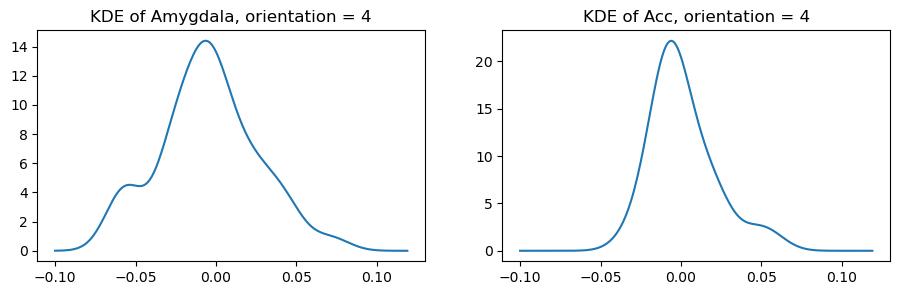

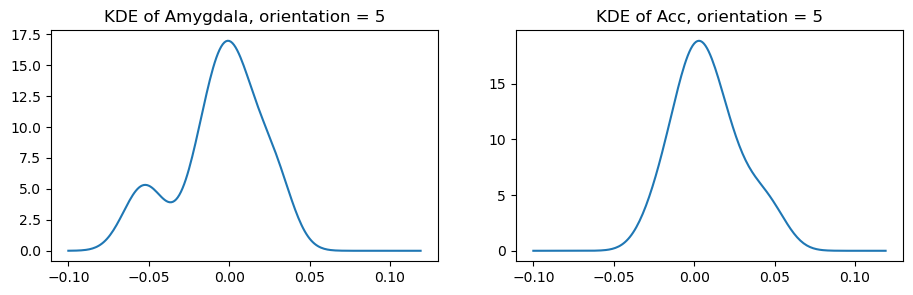

,c = 2,c = 3,c = 4,c = 5
amygdala,0.019062,0.000588,-0.00472,-0.005692
acc,-0.014769,0.001671,0.00131,0.008142


In [8]:
amy_mean = []
acc_mean = []
index = []

# display conditional KDEs of amygdala and acc when orientation = 2,3,4,5,6
for i in range(2,6):
    idx = np.where(n90y == i)[0]
    amygdala_sub = amygdala[idx] 
    acc_sub = acc[idx]
    
    fig, axes = plt.subplots(1,2, figsize=(11, 3))
    x = np.arange(-0.1, 0.12, 0.001)
        
    kde_amy = KernelDensity(kernel='gaussian', bandwidth = h_avg).fit(amygdala_sub.reshape(-1,1))
    log_density_amy = kde_amy.score_samples(x.reshape(-1,1))
    density_amy = np.exp(log_density_amy)
    axes[0].plot(x, density_amy)
    axes[0].set_title("KDE of Amygdala, orientation = " + str(i))
    
    kde_acc = KernelDensity(kernel='gaussian', bandwidth = h_avg).fit(acc_sub.reshape(-1,1))
    log_density_acc = kde_acc.score_samples(x.reshape(-1,1))
    density_acc = np.exp(log_density_acc)
    axes[1].plot(x, density_acc)
    axes[1].set_title("KDE of Acc, orientation = " + str(i))
    
    amy_mean += [np.mean(amygdala_sub)]
    acc_mean += [np.mean(acc_sub)]
    index += ['c = ' + str(i)]
    
    plt.show()

mean = pd.DataFrame({'amygdala': amy_mean, \
                                           'acc': acc_mean},
                                         index = index).T
display(mean)

### 2.e

The 3D histograms and heatmaps for the estimated conditional joint distribution, $p(amygdala, acc| orientation = c)$ are displayed in the following code chunk. It can be observed that the the conditional joint distribution  of **amygdala** and **acc** are different from $c = 2,3,4,5$. Therefore, there is a differnece between brain structures and political view.

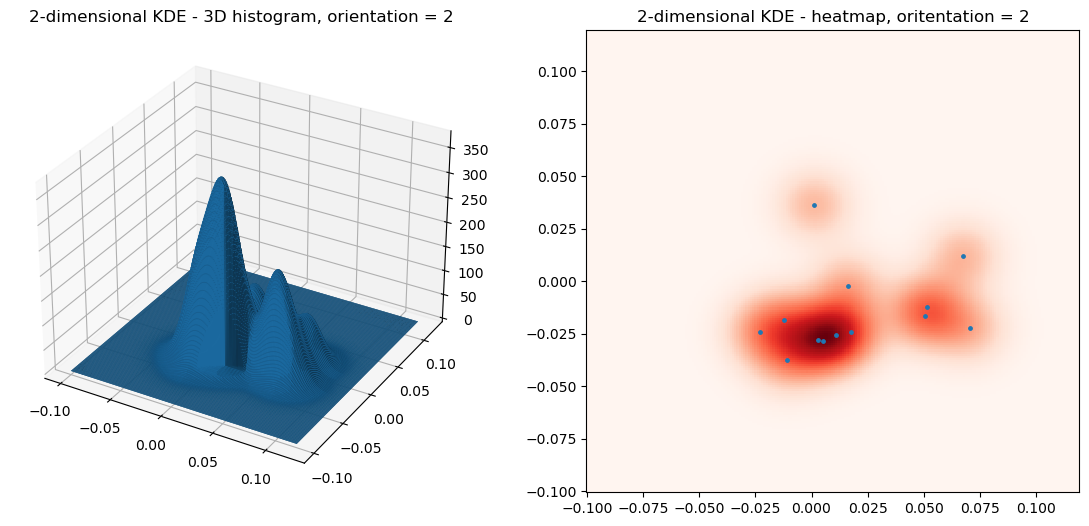

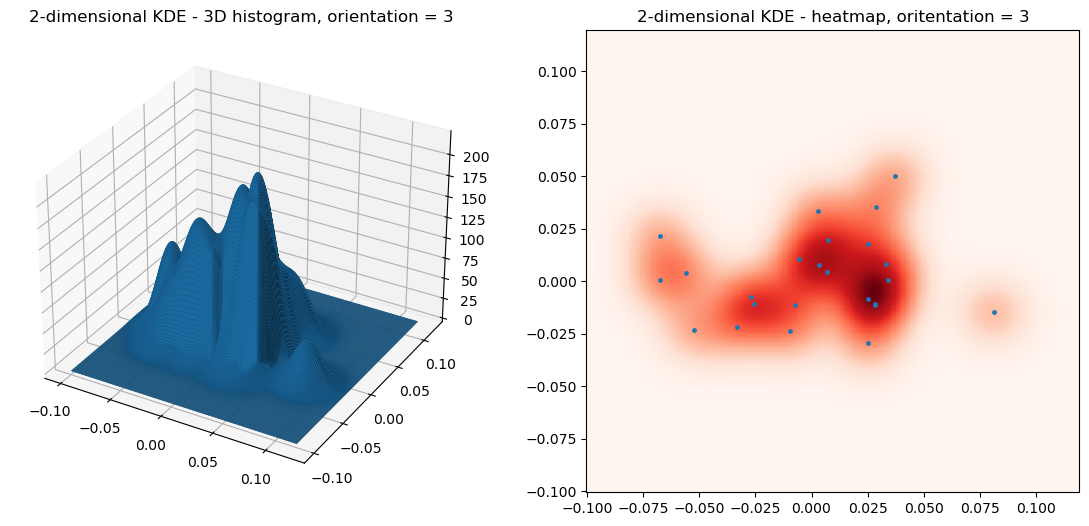

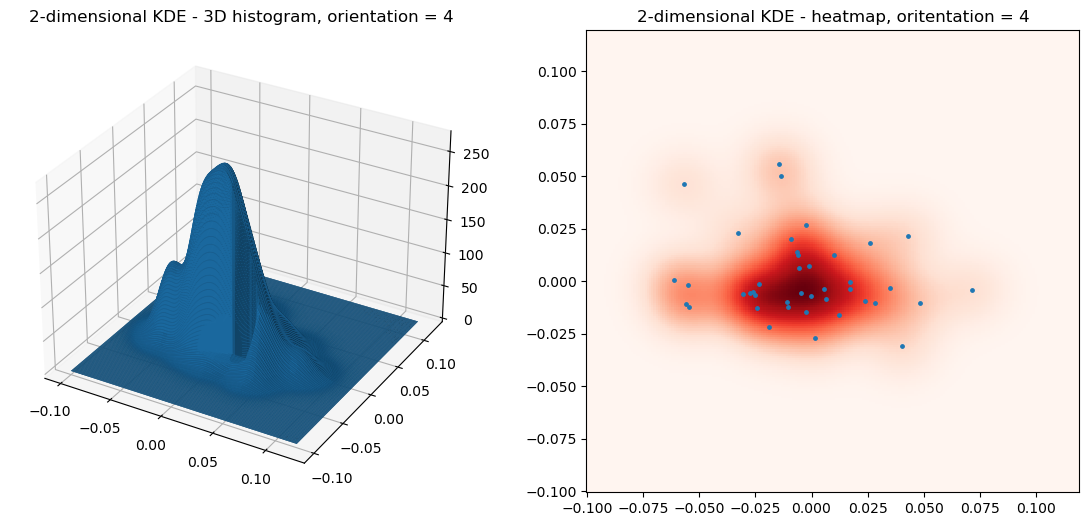

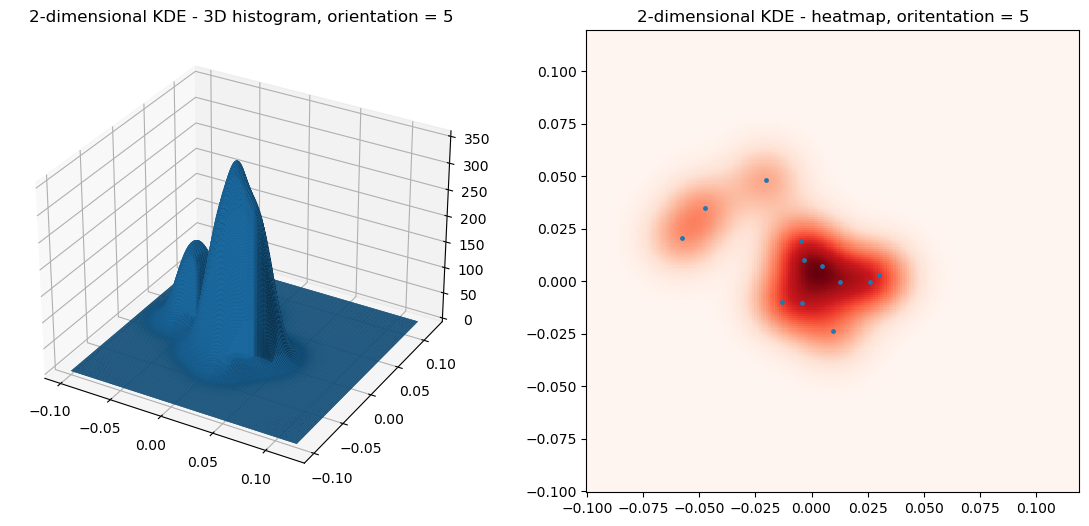

In [9]:
# display joint conditional KDEs of amygdala and acc when orientation = 2,3,4,5,6
for i in range(2,6):
    fig = plt.figure(figsize=(14, 6))
    ax = plt.subplot(1, 2, 1, projection = '3d')
    #ax = fig.add_subplot(111, projection='3d')

    idx = np.where(n90y == i)[0]
    n90data_sub = n90data[idx, :]

    x = np.arange(-0.1, 0.12, 0.001)
    xpos, ypos = np.meshgrid(x, x)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    pos = np.concatenate((xpos.reshape(-1,1), ypos.reshape(-1,1)), axis = 1)
        
    kde_joint = KernelDensity(kernel='gaussian', bandwidth = h_avg).fit(n90data_sub)
    log_density_joint= kde_joint.score_samples(pos)
    density_joint = np.exp(log_density_joint)
    
    zpos = np.zeros_like (xpos)

    ax.bar3d(xpos, ypos, zpos, 0.001, 0.001, density_joint, cmap = "Blues")
    plt.title("2-dimensional KDE - 3D histogram, orientation = " + str(i))

    # 2-dimensional KDE in heatmap
    ax = plt.subplot(1, 2, 2)
    zz = density_joint.reshape(x.shape[0], x.shape[0])
    ax.pcolormesh(x, x, zz, shading='auto', cmap="Reds")
    plt.scatter(n90data_sub[:, 0], n90data_sub[:,1], s=6)
    plt.title("2-dimensional KDE - heatmap, oritentation = " + str(i))
    plt.show()

## 3. Implementing EM for MNIST dataset

### 3.a

In the following code chunks, we preprocessed the data using PCA. We use the first two principle components to show the data points on the scatter plots. The first code chunk dispalys the data points on a scatter plot with their correct labels. The second code chunk implements the EM algorithm and shows the process of the algorithm's convergence in multiple scatter plots. At the end of the second code chunk, there is a line chat showing the relationship between the value of the log likelihood function and iteration numbers. It shows that the value of the log likelihood function first increases rapidly and then remains stable at a high level. This pattern shows that the EM algorithm is converging.

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


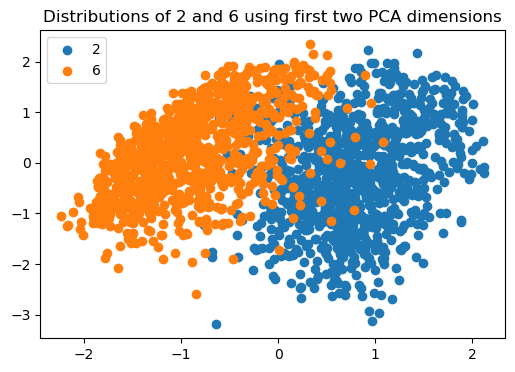

In [10]:
# read data
label_mat = sio.loadmat('./data/label')
data_mat = sio.loadmat('./data/data')
true_label = label_mat['trueLabel'].flatten()
data = data_mat['data'].T

# Perform PCA.
# #Project the original data into 4-dimensional vectors
m, n = data.shape
mean = np.mean(data, axis = 0)
xc = data - mean

C = np.dot(xc.T, xc)/m
d = 4  # reduced dimension
values, V = np.linalg.eig(C)
ind = np.argsort(-values)[0:d]
V = V[:, ind]
values = values[ind]

# project the data to the top 4 principal directions
pdata = np.dot(xc,V) / np.sqrt(values)

plt.figure(figsize=(6, 4))
plt.scatter(pdata[np.where(true_label == 2)[0], 0], pdata[np.where(true_label == 2)[0], 1], c = "#1f77b4", label = "2")
plt.scatter(pdata[np.where(true_label == 6)[0], 0], pdata[np.where(true_label == 6)[0], 1], c = '#ff7f0e', label = "6")
plt.title("Distributions of 2 and 6 using first two PCA dimensions")
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_multivariate.py:494: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray(x, dtype=float)
C:\Users\WenyuSui\AppData\Local\Temp\ipykernel_18992\3009046912.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  mu[kk] = pdata.T @ tau[:, kk] / np.sum(tau[:, kk], axis=0)


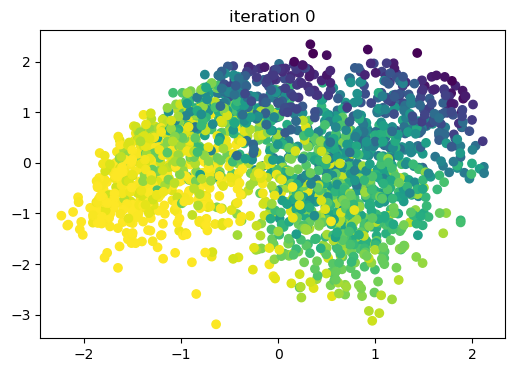

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_multivariate.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  cov = np.asarray(cov, dtype=float)


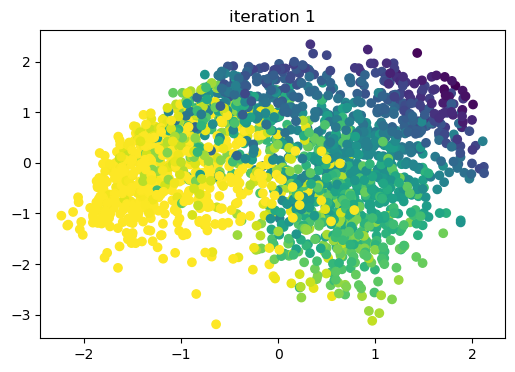

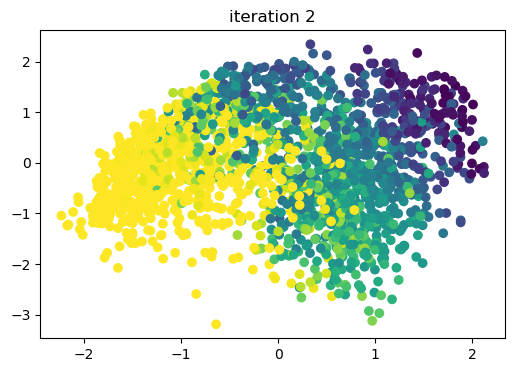

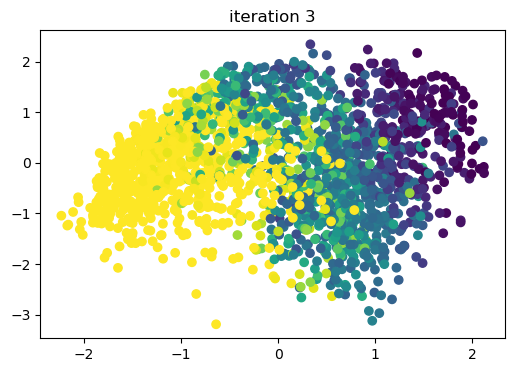

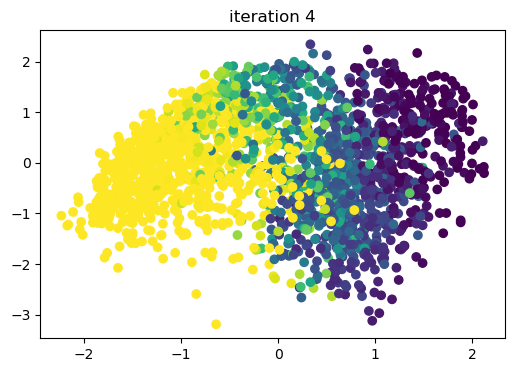

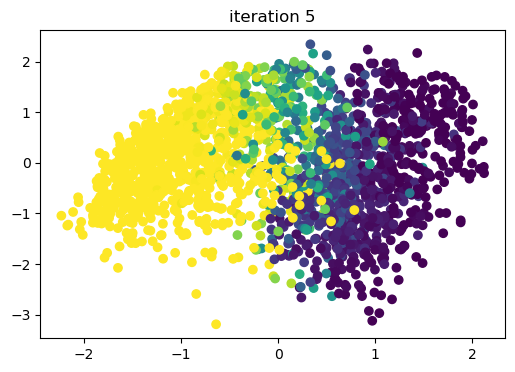

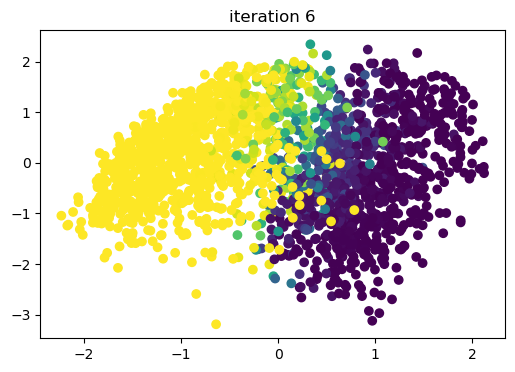

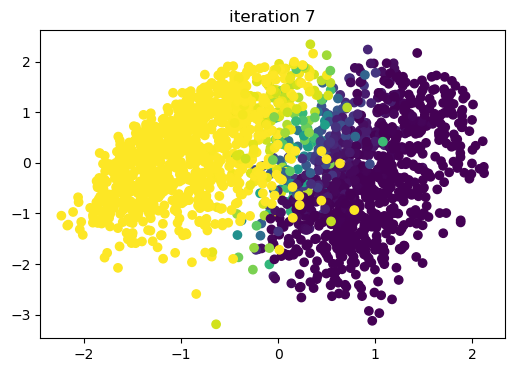

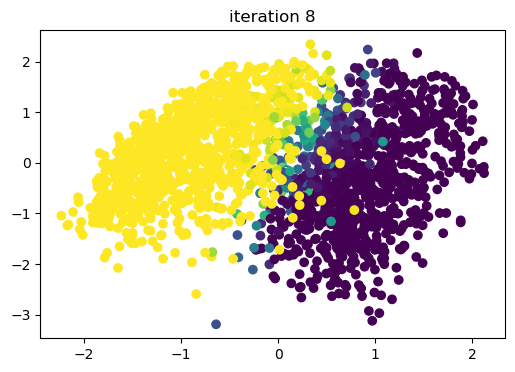

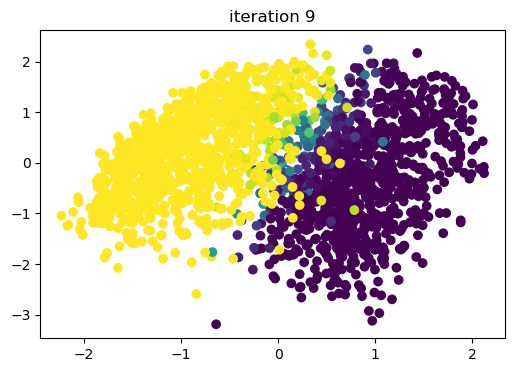

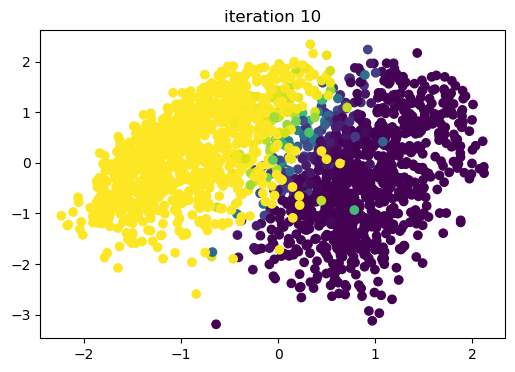

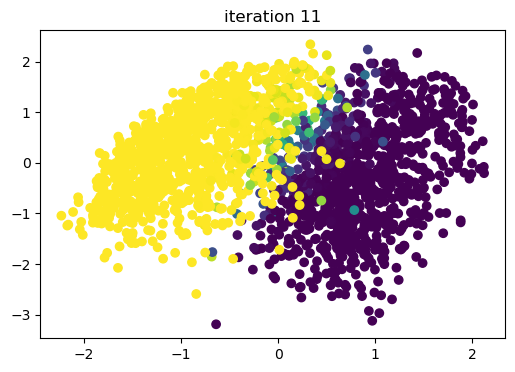

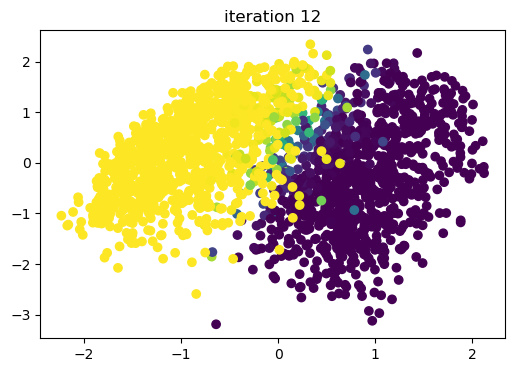

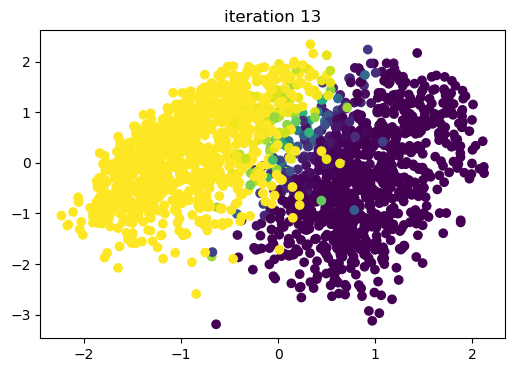

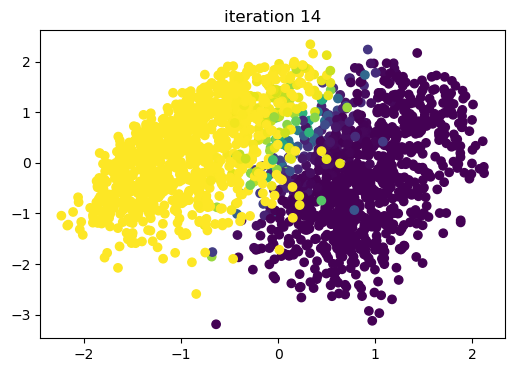

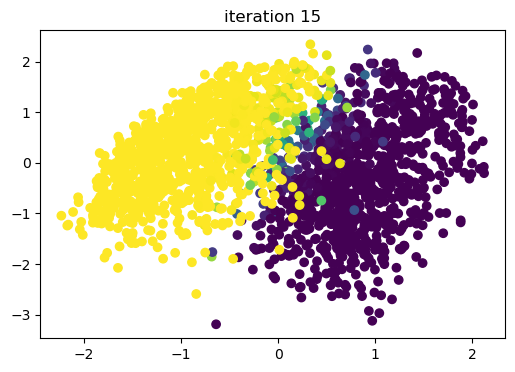

training coverged


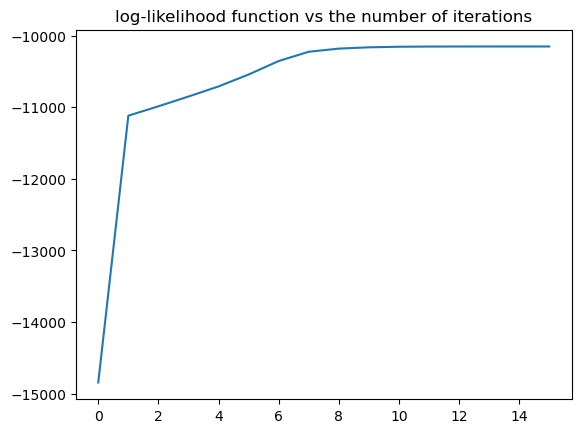

In [11]:
# perform EM algorithm MNIST data
# number of mixtures
K = 2

# initialize prior
pi = np.random.random(K)
pi = pi / np.sum(pi)

# initial mean and covariance
mu = np.random.randn(K, d)
mu_old = mu.copy()

sigma = []
for ii in range(K):
    # to ensure the covariance psd
    # np.random.seed(seed)
    dummy = np.random.randn(d, d)
    sigma.append(dummy @ dummy.T + np.identity(d))

# initialize the posterior
tau = np.full((m, K), fill_value=0.)

maxIter = 100
tol = 1e-3

log_likelihood = []
for ii in range(maxIter):
    # E-step
    for kk in range(K):
        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m, 1)
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))

    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk]) / m

        # update component mean
        mu[kk] = pdata.T @ tau[:, kk] / np.sum(tau[:, kk], axis=0)

        # update cov matrix
        dummy = pdata - np.tile(mu[kk], (m, 1))  # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:, kk]) @ dummy / np.sum(tau[:, kk], axis=0)

    log_likelihood += [np.sum(np.log(sum_tau))]

    plt.figure(figsize=(6, 4))
    plt.scatter(pdata[:, 0], pdata[:, 1], c = tau[:, 0])
    plt.title('iteration '+ str(ii))
    plt.show()
    plt.pause(0.1)

    if np.linalg.norm(mu - mu_old) < tol:
        print('training coverged')
        break
    mu_old = mu.copy()
    if ii == 99:
        print('max iteration reached')
        break
        
# show the log-likelihood function vs the number of iterations
plt.figure()
plt.plot(range(len(log_likelihood)), log_likelihood)
plt.title("log-likelihood function vs the number of iterations")
plt.show()

### 3.b

The weight, mean and convariance matrix of each component are displayed in the following code chunk.
The mean of each component is mapped into the original space and displayed as a 28 * 28 image. The convariance matrix of each component is displayed in a 4* 4 heatmap.

Wight of component  1 :  0.5134 

Mean of each variable of component  1 : 
[-0.8102  0.2828 -0.0577 -0.0143]


Mapping the mean of component  1  into the original space:


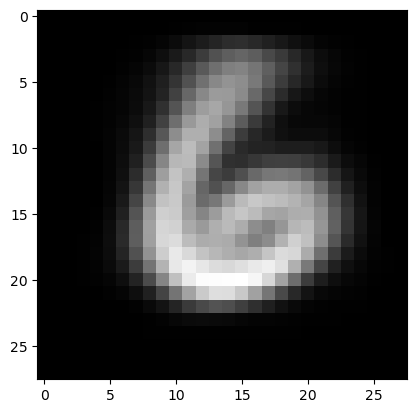



Intensity of Covariance Matrix of Component  1


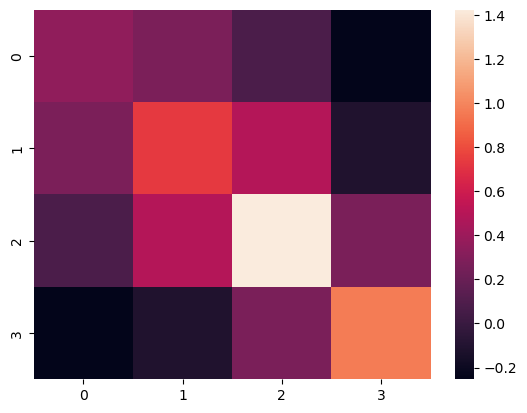



Wight of component  2 :  0.4866 

Mean of each variable of component  2 : 
[ 0.8549 -0.2984  0.0609  0.0151]


Mapping the mean of component  2  into the original space:


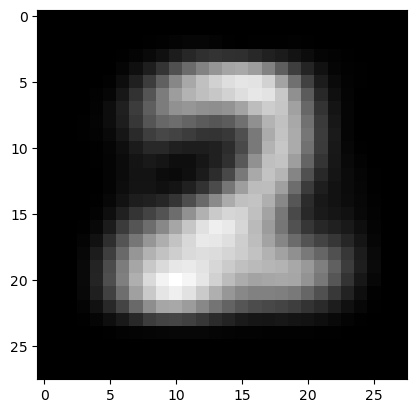



Intensity of Covariance Matrix of Component  2


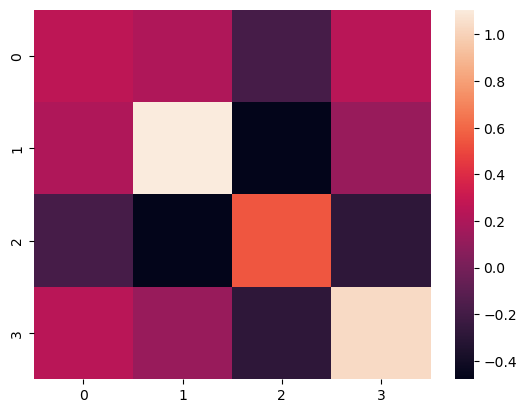

In [12]:
for kk in range(K):
    print("Wight of component ", kk+1, ": ", round(pi[kk],4),"\n")
    print("Mean of each variable of component ", kk+1, ": ")
    print(np.round(mu[kk, :],4))
    print("\n")
    
    pixels = V @ np.diag(np.sqrt(values)) @ mu[kk,:].reshape((d,1)) + mean.reshape((-1,1))
    print("Mapping the mean of component ", kk+1, " into the original space:")
    functions.show_image(28, 28, pixels.real)
    print("\n")

    seaborn.heatmap(sigma[kk].real)
    print('Intensity of Covariance Matrix of Component ', kk+1)
    plt.show()
    print("\n")

### 3.c

The following code chunks respectively show the classification results of the EM algorithm (GMM) and k-means clustering. For the EM algorithm, we determine that data point $i$ belongs to the component which has higher $\tau_{k}^i$ value.

From the results below, we can see that the EM algorithm and k-means clustering have similar mis-classification rate for digit 6, but the EM algorithm has significantly lower mis-sclassification rate for digit 2. Besides, the EM algorithm also has lower overall mis-classification rate. Therefore, we conclude that the EM algorithm (GMM) achieves better performance than k-means clustering.

In [13]:
# determin the class that each data point belongs to
Class = np.argmax(tau, axis = 1)

# determines the true labels of each class and the mis-classification rate
assigned_class, correctly_assigned, true_counts, purities, mis_classification_rates = \
    functions.MNIST_true_labels_and_purity(Class, true_label)

EM_result = pd.DataFrame({'assigned class': assigned_class, \
                          'Correctly Assigned': correctly_assigned, \
                          "True Counts": true_counts, \
                          'purity': purities,\
                          'Mis-classification Rate': mis_classification_rates})

print("Mis-classification Rate and Assigned Label of each Component: ")
display(EM_result)

print("Overall Mis-classification Rate - EM Algorithm: ")
print(round(1 - np.sum(correctly_assigned) / np.sum(true_counts),4))

Mis-classification Rate and Assigned Label of each Component: 


,assigned class,Correctly Assigned,True Counts,purity,Mis-classification Rate
0,6,949,1016,0.934055,0.065945
1,2,965,974,0.990760,0.009240


Overall Mis-classification Rate - EM Algorithm: 
0.0382


In [14]:
# implement K_means clustering
Class_kmeans, xcentroid = (functions.k_means_MNIST_l2(data,2))

#functions.show_image(28, 28, xcentroid[0, :])
#functions.show_image(28, 28, xcentroid[1, :])


# determines the true labels of each class and the mis-classification rate
assigned_class, correctly_assigned, true_counts, purities, mis_classification_rates = \
    functions.MNIST_true_labels_and_purity(Class_kmeans, true_label)

kmeans_result = pd.DataFrame({'assigned class': assigned_class, \
                          'Correctly Assigned': correctly_assigned, \
                          "True Counts": true_counts, \
                          'purity': purities,\
                          'Mis Classification Rate': mis_classification_rates})

print("Mis-classification Rate and Assigned Label of each Component - K means Clustering ")
display(kmeans_result)

print("Overall Mis-classification Rate - K means clustering: ")
print(round(1 - np.sum(correctly_assigned) / np.sum(true_counts),4))

Mis-classification Rate and Assigned Label of each Component - K means Clustering 


,assigned class,Correctly Assigned,True Counts,purity,Mis Classification Rate
0,2,957,991,0.965691,0.034309
1,6,924,999,0.924925,0.075075


Overall Mis-classification Rate - K means clustering: 
0.0548


## 4. De-bias review system using EM.

### 4.1

Since $y^{(p)}$ ~ $N(\mu_p,\sigma_p^2)$ ,    $z^{(r)}$ ~ $N(v_r,r_r^2)$   and  $y^{(p)}$ is indenpendent from $z^{(r)}$, we can derive that 

$x^{(pr)} = y^{(p)} + z^{(r)} +\epsilon^{(pr)}$  ~ $N(\mu_p + v_r, \sigma_p^2 + r_r^2 + \sigma^2)$

$p (y^{(p)}, z^{(r)}) = p(y^{(p)}) \cdot p(z^{(r)}) = N(y^{(p)} | \mu_p, \sigma_p^2) \cdot N(z^{(r)} | v_r, r_r^2)$

Therefore, 

$p(y^{(p)}, z^{(r)} | x^{(pr)}, \theta) = \frac{p(x^{(pr)} | y^{(p)}, z^{(r)}) \cdot p(y^{(p)}, z^{(r)})}{p(x^{(pr)})}
= \frac{N(x^{(pr)} |y^{(p)} + z^{(r)}, \sigma^2) \cdot N(y^{(p)} | \mu_p, \sigma_p^2) \cdot N(z^{(r)} | v_r, r_r^2)}
{N(x^{(pr)} | \mu_p + v_r, \sigma_p^2 + r_r^2 + \sigma^2)}$

If we define $\tau_{pr} = p(y^{(p)}, z^{(r)} | x^{(pr)}, \theta)$

Then,
 
$Q_{pr}(\theta'|\theta) $ <br> <br>
$= E_{\tau_{pr}} [log \space p(y^{(p)}, z^{(r)}, x^{(pr)}) | x^{(pr)}, \theta] $ <br> <br>
$= \int_\infty^\infty \int_\infty^\infty \tau_{pr} \cdot log[N(x^{(pr)} |y^{(p)} + z^{(r)}, \sigma^2) \cdot N(y^{(p)} | \mu_p, \sigma_p^2) \cdot N(z^{(r)} | v_r, r_r^2)] \space \space dy^{(p)} \space dz^{(r)}$